In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from os import stat
from FileScann import FileScann
from Print import *
import random

# Data Structure

In [2]:
class ImageBase:
    def __init__(self, path: str):
        self._path = Path(path)
        self._classes = {None}
        
        # Varrendo os arquivos
        scann = FileScann()
        scann.scann(self._path)   
        self._data = pd.DataFrame(scann.fill, columns=['id'])
        
        # Adicionando informações da classes ao DataFrame
        self._data['classe'] = self._data['id'].map(lambda path: getattr(path, 'stem'))
        
        self._data['classe'] = self._data.classe.str.extractall(r'([a-zA-z])').unstack(-1, '').sum(1)
        self._data.classe.apply(lambda x: self._classes.update(list(x))); self._classes.remove(None)
        self._data['classe'] = self._data.classe.apply(sorted)
        # _classes já contém todas as classes
        
        # Mapiando cada lista/classe com o aux_map
        aux_map = {}
        for i, classe in enumerate(sorted(self._classes)):
            aux_map[classe] = i
        self._classes = aux_map
        
        # Separando as classes em colunas
        for new_column in self._classes.keys():
            self._data[new_column] = False
        
        # Levando as informações da classes para sua respectiva coluna
        def many_hot(linha): # Notation "One-Hot"
            self._data.loc[linha, self._data.loc[linha].classe] = True
        self._data.index.to_series().apply(many_hot)
        
        # Index
        self._data.index = self._data['id'].map(lambda path: getattr(path, 'name'))
        self._data.rename(columns={'id': 'path'}, inplace=True)
        
        # Adicionando informação sobre o tamanho dos arquivos
        self._data['size'] = (str(self._path) + '\\' + self._data.index).to_series(index=self._data.index).apply(
            lambda file: stat(file).st_size/1048576
        )
        
        # Meta
        self._meta = {
            "Classes": list(self._classes.keys()),
            "Número de Classes": len(self._classes),
            "Número de Imagens": self._data.shape[0],
            "Tamanho Total (MB)": self._data['size'].sum().round(2),
            "Resolução das Imagens": '???'}
        
        # Informações sobre Classes
        self._info_classes = {}
        with open('./classes.csv', 'r') as info_classes:
            info_classes.readline()
            for linha in info_classes:
                info = linha.strip().split(',')
                self._info_classes[info[1]] = info[0]
        self._info_classes = pd.DataFrame(
            [self._info_classes, self._classes, self._data.drop(columns=['path', 'classe', 'size']).sum()],
            index=['Classe', 'Código', 'Número de Amostras']
            ).T.sort_values('Código')                
    
    @staticmethod
    def __getSize(file: str):
        return stat(file).st_size / 1048576
    
    @property
    def path(self) -> str:
        return self._path
    
    @property
    def data(self) -> pd.DataFrame:
        return self._data
    
    @property
    def classes(self) -> dict:
        return self._classes
    
    @property
    def meta(self):
        return self._meta
    
    @property
    def info_classes(self):
        return self._info_classes
    
    def __getitem__(self, idx):
        return self.data.iloc[idx]
    
    def getById(self, id: str):
        return plt.imread(self.path.joinpath(id))

    def getSampleOfClass(self, n: int, label: str = '') -> tuple:
        if label != '': condition = self.data[label]
        else: condition = np.ones(self.data.shape[0], dtype=bool)
        
        title = ['Img ' + str(i) for i in range(1, n+1)]
        return self.data[condition].sample(n), title
    
    def meta_dados():
        pass

# Amostra da Oganização dos Arquivos

In [3]:
x=ImageBase("./ImageBase/")
x.data.head()

,path,classe,C,F,H,M,N,O,P,R,T,X,size
id,,,,,,,,,,,,,
CMO.JPG,ImageBase\CMO.JPG,"[C, M, O]",True,False,False,True,False,True,False,False,False,False,1.809123
CMT.JPG,ImageBase\CMT.JPG,"[C, M, T]",True,False,False,True,False,False,False,False,True,False,1.776771
COM.JPG,ImageBase\COM.JPG,"[C, M, O]",True,False,False,True,False,True,False,False,False,False,1.835710
COMT.JPG,ImageBase\COMT.JPG,"[C, M, O, T]",True,False,False,True,False,True,False,False,True,False,1.968816
COPMT.JPG,ImageBase\COPMT.JPG,"[C, M, O, P, T]",True,False,False,True,False,True,True,False,True,False,1.947704


# Metadados 

In [4]:
x.meta

{'Classes': ['C', 'F', 'H', 'M', 'N', 'O', 'P', 'R', 'T', 'X'],
 'Número de Classes': 10,
 'Número de Imagens': 213,
 'Tamanho Total (MB)': 486.27,
 'Resolução das Imagens': '???'}

# Metadados das Classes

In [5]:
x.info_classes

,Classe,Código,Número de Amostras
C,Carregador,0,47
F,Faca,1,88
H,Chinelo,2,69
M,Mouse,3,46
N,Controle,4,88
O,Cortador de Unha,5,55
P,Protetor Solar,6,51
R,Parafuso,7,88
T,Tesoura,8,51
X,Chave,9,100


# Visualização de Amostras

In [6]:
def printClass(base: ImageBase, label: str, n: int):
    imgs, titles = base.getSampleOfClass(n, label)
    imgs = imgs.index.to_series().apply(base.getById).to_list()#;print(imgs);return
    
    plot_imgs(imgs, titles, min(3, n))

def showClasses(base: ImageBase):
    imgList = []
    titleList =[]
    
    for classe in base.classes.keys():
        img, title = base.getSampleOfClass(1, classe)
        img = img.index.to_series()[0]
        img = base.getById(img)
        
        title = classe
        
        imgList.append(img)
        titleList.append(title)
    # End For
    
    plot_imgs(imgList, titleList, min(3, len(base.classes)))

## Visualizando uma Classe Específica

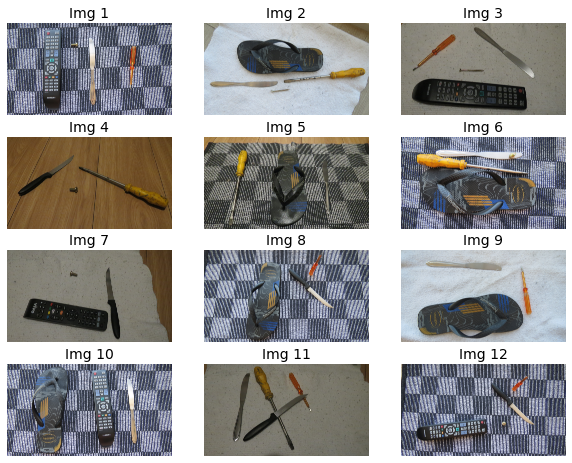

In [7]:
printClass(x, 'F', 12)

## Visualizando um Exemplo de Cada Classe

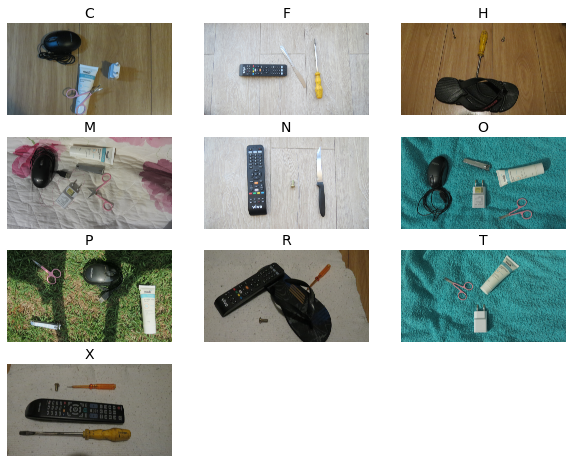

In [8]:
showClasses(x)